In [2]:
# import system libs 
import os
import time
import shutil
import itertools

# import data handling tools 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import DenseNet201

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')



from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img , img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPool2D, Dense
import matplotlib.pyplot as plt
import numpy as np
# from skimage import transform
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model 


2024-03-20 17:48:08.702084: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 17:48:08.702179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 17:48:08.841348: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules loaded


In [3]:
data_dir = '/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv'
data = pd.read_csv(data_dir)
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [4]:
Label = data["label"]
Data = data.drop(columns=["label"])

In [5]:
data["label"].value_counts()

label
4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: count, dtype: int64

In [6]:
from imblearn.over_sampling import RandomOverSampler 

oversample = RandomOverSampler()
Data, Label  = oversample.fit_resample(Data, Label)
Data = np.array(Data).reshape(-1, 28, 28, 3)
print('Shape of Data :', Data.shape)

Shape of Data : (46935, 28, 28, 3)


In [7]:
Label = np.array(Label)
Label

array([2, 2, 2, ..., 6, 6, 6])

In [8]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

In [9]:
import numpy as np

# Pad images with additional pixels
padded_data = np.pad(Data, ((0, 0), (2, 2), (2, 2), (0, 0)), mode='constant')

# Split the padded data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_data, Label, test_size=0.25, random_state=49)



In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(35201, 32, 32, 3)
(35201,)
(11734, 32, 32, 3)
(11734,)


In [11]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [12]:
datagen = ImageDataGenerator(rescale=(1./255)
                             ,rotation_range=300
                             ,zoom_range = 0.1
                             ,width_shift_range=0.1
                             ,height_shift_range=0.1)

testgen = ImageDataGenerator(rescale=(1./255))

In [13]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.00001)

In [55]:
# from tensorflow.keras.applications import Resnet50
# Create Model Structure
base_model = keras.applications.EfficientNetV2L(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(units=256, activation='relu', kernel_initializer='he_normal')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(units=32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.L1L2())(x)
x = keras.layers.BatchNormalization()(x)
output = keras.layers.Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier')(x)

model = Model(inputs=base_model.input, outputs=output)

model.summary()

473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 32, 32, 3) │          0 │ input_layer_5[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 16, 16,    │        864 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 16, 16,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 16, 16,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 16, 16,    │      9,216 │ stem_activation[… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 16, 16,    │        128 │ block1a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 16, 16,    │          0 │ block1a_project_… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 16, 16,    │          0 │ block1a_project_… │
│                     │ 32)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 16, 16,    │      9,216 │ block1a_add[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 16, 16,    │        128 │ block1b_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 16, 16,    │          0 │ block1b_project_… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 16, 16,    │          0 │ block1b_project_… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 16, 16,    │          0 │ block1b_drop[0][… │
│                     │ 32)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_co… │ (None, 16, 16,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_bn  │ (None, 16, 16,    │        128 │ block1c_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1c_project_ac… │ (None, 16, 16,    │          0 │ block1c_project_

 Total params: 118,120,167 (450.59 MB)

 Trainable params: 117,606,631 (448.63 MB)

 Non-trainable params: 513,536 (1.96 MB)

In [56]:

import keras
METRICS = [
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=METRICS)

In [58]:
history = model.fit(X_train, y_train, epochs=26,
                    batch_size=128,
                    validation_data=(X_test, y_test),
                    callbacks=[learning_rate_reduction])

Epoch 1/26
276/276 ━━━━━━━━━━━━━━━━━━━━ 430s 2s/step - accuracy: 0.5021 - loss: 1.3534 - precision: 0.6695 - recall: 0.3424 - val_accuracy: 0.8566 - val_loss: 0.4494 - val_precision: 0.8737 - val_recall: 0.8445 - learning_rate: 0.0010
Epoch 2/26
276/276 ━━━━━━━━━━━━━━━━━━━━ 56s 201ms/step - accuracy: 0.8742 - loss: 0.3737 - precision: 0.8993 - recall: 0.8487 - val_accuracy: 0.9251 - val_loss: 0.2458 - val_precision: 0.9301 - val_recall: 0.9203 - learning_rate: 0.0010
Epoch 3/26
276/276 ━━━━━━━━━━━━━━━━━━━━ 55s 199ms/step - accuracy: 0.9394 - loss: 0.1919 - precision: 0.9464 - recall: 0.9336 - val_accuracy: 0.9616 - val_loss: 0.1292 - val_precision: 0.9634 - val_recall: 0.9594 - learning_rate: 0.0010
Epoch 4/26
276/276 ━━━━━━━━━━━━━━━━━━━━ 57s 207ms/step - accuracy: 0.9590 - loss: 0.1321 - precision: 0.9631 - recall: 0.9556 - val_accuracy: 0.9651 - val_loss: 0.1350 - val_precision: 0.9662 - val_recall: 0.9646 - learning_rate: 0.0010
Epoch 5/26
276/276 ━━━━━━━━━━━━━━━━━━━━ 54s 196ms/step

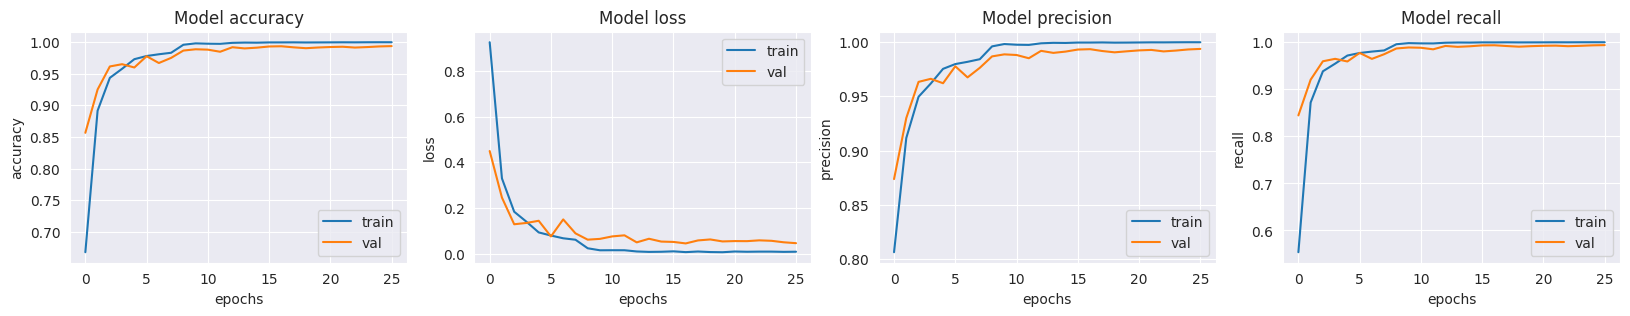

In [59]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss', 'precision', 'recall']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

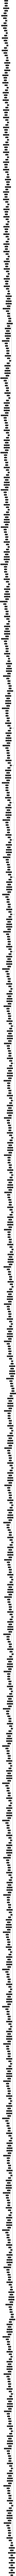

In [60]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

**Show training history**

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='macro')
recall = recall_score(y_test_classes, y_pred_classes, average='macro')
f1 = f1_score(y_test_classes, y_pred_classes, average='macro')
kappa = cohen_kappa_score(y_test_classes, y_pred_classes)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Kappa Score:", kappa)



  5/367 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step 

W0000 00:00:1710962899.835182     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


367/367 ━━━━━━━━━━━━━━━━━━━━ 54s 84ms/step
Accuracy: 0.9937787625703085
Precision: 0.9939160789141896
Recall: 0.9937400731610986
F1-score: 0.9937636966186253
Kappa Score: 0.9927411520508325


W0000 00:00:1710962930.755610     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


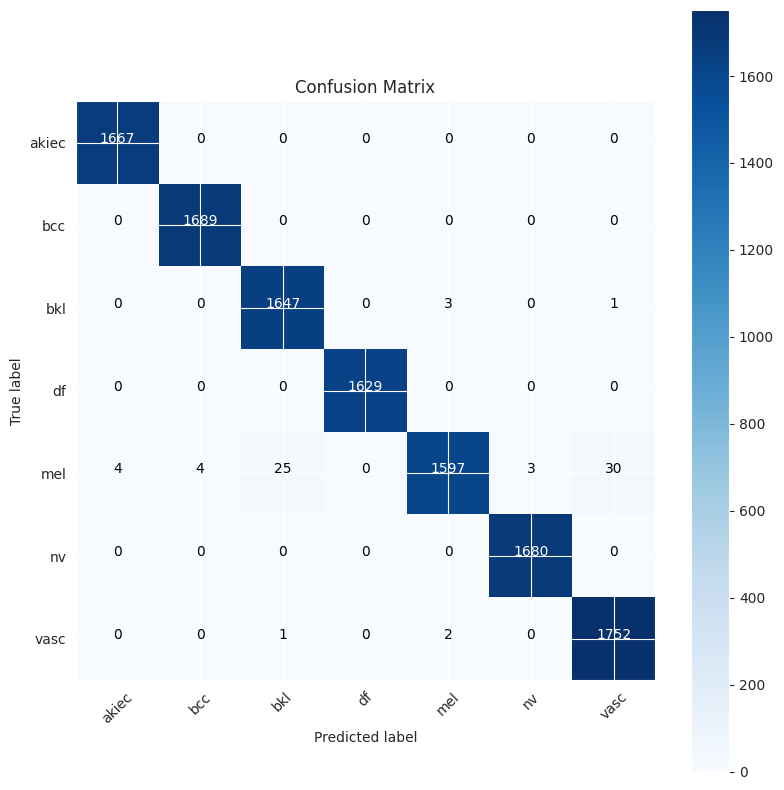

In [62]:
# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**Save model**

In [ ]:
# model.save('SkinCancerDetection.h5')